In [1]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import texthero as hero
from texthero import preprocessing
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
import nltk
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import  StandardScaler, MinMaxScaler
import sys

print('Matplotlib Version: ' + mpl.__version__)
print('NumPy Version: ' + np.version.full_version)
print('Python Version: ' + sys.version)

import datetime
now  = datetime.datetime.now().isoformat()
print('Ran on ' + now)

pd.set_option("display.max_row",140000)

Matplotlib Version: 3.3.1
NumPy Version: 1.19.1
Python Version: 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
Ran on 2020-11-01T09:55:57.424217


In [2]:
data = pd.read_csv('data_application_smart.csv',sep = '\t', low_memory=False )

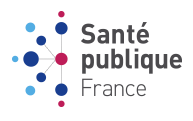

# <span class="bg-primary">Idée d'application<span>

# <span class="bg-danger">Introduction<span>
    
L'idée d'application dont nous testerons la faisabilité portera sur __l'alimentation en cas de diabète__. Notre application se voudra clairement informative et simple d'utilisation. Elle consistera à donner aux personnes diabétiques des informations sur les produits de la base de données d'_Open Food Facts_ les plus pertinentes possibles et les mieux adaptées au régime alimentaire préconisé aux diabétiques. 

# <span class="bg-danger">Sommaire<span>
    
__<span class="bg-info">1.<span>__ __Sélection des variables__ 
___ 
__<span class="bg-info">2.<span>__ __Mise à l'échelle et score__ 
___   
__<span class="bg-info">3.<span>__ __Traitement de texte__ 

<span class="bg-warning">Preprocessing avec TEXTHERO et NLTK<span>

<span class="bg-warning">Vectorisation avec SKLearn<span>
    
 <span class="bg-success">TF-IDF<span> 
     
 <span class="bg-success">Similarité cosinus<span>  
___
__<span class="bg-info">4.<span>__ __Moteur de recommandation__
     
 <span class="bg-warning">Quelques exemples de recherches pour tester le moteur de recommandation<span>
     
 <span class="bg-warning">Ajout d'une modeste interface utilisateurs<span>   

## <span class="bg-info">1 : Sélection des variables pour le score<span> 

In [3]:
data.head(4)

,product_name,categories,image_url,stores,countries_tags,nutriscore_grade,nutrition_score_fr_100g,nova_group,carbohydrates_100g,sugars_100g,fiber_100g,ratio_sucre,sucres_lents_100g
0,moutarde au moût de raisin,"['Epicerie', ' Condiments', ' Sauces', ' Mouta...",https://static.openfoodfacts.org/images/produc...,courte paille,en:france,d,18.0,4.0,29.0,22.0,0.0,75.862069,7.0
1,Salade de carottes râpées,"['Plats préparés', ' Légumes préparés', ' Caro...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,b,1.0,4.0,5.3,3.9,3.4,73.584906,1.4
2,Tarte noix de coco,"['Tartes', ' Tartes sucrées', ' Tartes à la no...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,d,14.0,4.0,27.3,21.9,4.4,80.219780,5.4
3,Compote de poire,"['Aliments et boissons à base de végétaux', "" ...",https://static.openfoodfacts.org/images/produc...,NaN,en:france,a,-2.0,4.0,36.0,27.0,3.6,75.000000,9.0


In [4]:
data.shape

(141990, 13)

<AxesSubplot:>

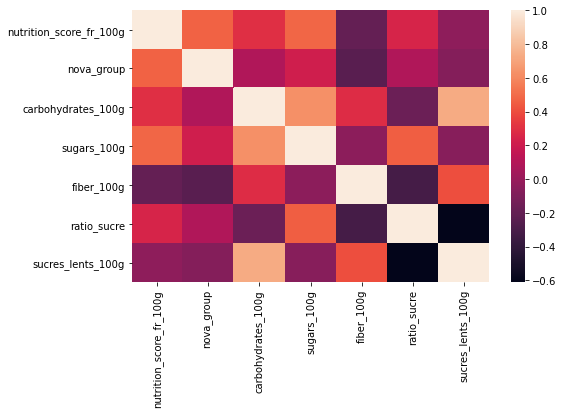

In [5]:
col_to_keep = ['nutrition_score_fr_100g', 'nova_group', 'carbohydrates_100g','sugars_100g', 'fiber_100g',"ratio_sucre", "sucres_lents_100g"]
plt.figure(figsize = (8,5))
sns.heatmap(data[col_to_keep].corr())

__La variable 'ratio_sucre'__ a été créée par nos soins.
Pour la calculer : (sucres rapides = "sugars_100g) / (Glucides total="carbohydrates_100g") * 100 Plus le pourcentage est élevé, plus le produit est à déconseiller à une personne diabétique.

Nous la préférerons à la variable 'sugars_100g' car elle moins corrélée aux autres variables. Nous gardons également pour le score la variable 'nutrition_score_100g' indicateur de la qualité nutritionnelle, 'nova-group' indicateur de la transformation du produit et 'fiber_100g'.

## <span class="bg-danger">Indicateurs alimentation - diabète<span>

- ### <span class="bg-warning">Indicateur qualité nutritionnelle du produit<span>  
(produits ni trop gras, ni trop sucrés, ni trop salés) __'nutrition_score_100g'__
- ### <span class="bg-warning">Indicateur degré de transformation du produit<span>
(on récupère indirectement des informations sur __l'index glycémique__) : __'nova_group'__
- ### <span class="bg-warning">Indicateur sucres rapides<span>
(à défavoriser au profit des sucres complexes) : __'ratio_sucre'__
- ### <span class="bg-warning">Indicateur fibres<span> 
(non assimilables mais qui participent à l'assimilation des glucides, elles ralentissent leur absorption, empêchant le taux de glycémie de monter brutalement. Elles réduisent aussi le taux de cholestérol sanguin.): __'fiber_100g__

Le score sera calculé en sommant les 3 premiers indicateurs (plus la note est basse, meilleur est l'aliment) et en enlevant l'indicateur fibre (plus la quantité est élevée, meilleur est l'aliment).

__Les aliments à conseiller dans le cadre d'un régime alimentaire compatible avec le diabète seront ceux dont la note sera la plus basse.__

<AxesSubplot:>

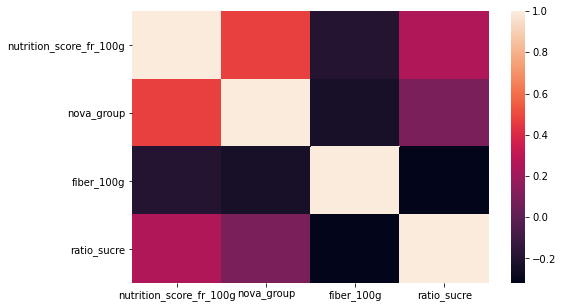

In [6]:
col_to_keep = ['nutrition_score_fr_100g', 'nova_group','fiber_100g',"ratio_sucre"]
plt.figure(figsize = (8,5))
sns.heatmap(data[col_to_keep].corr())

## <span class="bg-info">2 : Mise à l'échelle du jeu de données et score<span> 

In [7]:
data.columns

Index(['product_name', 'categories', 'image_url', 'stores', 'countries_tags',
       'nutriscore_grade', 'nutrition_score_fr_100g', 'nova_group',
       'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'ratio_sucre',
       'sucres_lents_100g'],
      dtype='object')

In [8]:
data['sucres_lents_100g'] = data.carbohydrates_100g - data.sugars_100g

### <span class="bg-success">Mise à l'échelle<span>

In [9]:
#Fonction pour visualiser les courbes de distribution des 4 indicateurs après mise à l'échelle.
import matplotlib.patches as mpatches
def plotGraph(pscaled_df):
    fig, ax = plt.subplots(1, figsize=(16, 6))
    fig.suptitle("Après mise à l'échelle", fontsize=15)
    for col in pscaled_df.columns:
        sns.kdeplot(pscaled_df[col])
        
    blue_patch = mpatches.Patch(color='blue', label='Nutrition_score_fr_100g')
    orange_patch = mpatches.Patch(color='orange', label='nova_group')
    green_patch = mpatches.Patch(color='green', label='ratio_sucre')
    red_patch = mpatches.Patch(color='red', label='fiber_100g')
    plt.legend(handles=[blue_patch,orange_patch, green_patch, red_patch])
    plt.show()

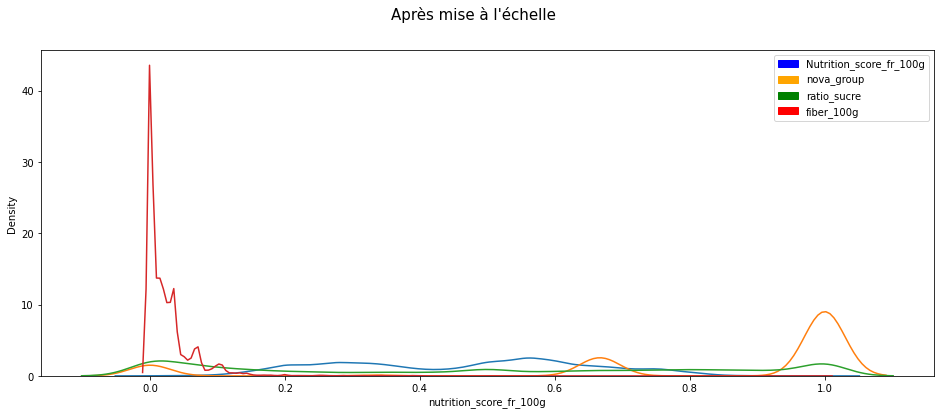

In [10]:
#Mise à l'échelle avec MinMaxScaler()
scaler = MinMaxScaler()
keepCols = ['nutrition_score_fr_100g', 'nova_group','ratio_sucre','fiber_100g']
data_scaled = scaler.fit_transform(data[keepCols])
data_scaled = pd.DataFrame(data_scaled, columns = keepCols)
plotGraph(data_scaled)

In [11]:
data_scaled.head(4)

,nutrition_score_fr_100g,nova_group,ratio_sucre,fiber_100g
0,0.64,1.0,0.758621,0.000
1,0.30,1.0,0.735849,0.034
2,0.56,1.0,0.802198,0.044
3,0.24,1.0,0.750000,0.036


### <span class="bg-success">Score<span>

In [12]:
#Fonction pour calculer le score des produits.
def score(row):
    return (row['nutrition_score_fr_100g'] + row['nova_group'] + row['ratio_sucre'] - row['fiber_100g'])   

In [13]:
data_scaled['Score']= data_scaled.apply(score, axis=1)

In [14]:
data_scaled["product_name"] = data.product_name
data_scaled["image_url"] = data.image_url
data_scaled["stores"] = data.stores
data_scaled["categories"] = data.categories
data_scaled["countries_tags"]= data.countries_tags

In [15]:
data_scaled.shape

(141990, 10)

In [16]:
data_scaled = data_scaled[['product_name','image_url','stores','categories','nutrition_score_fr_100g','nova_group','fiber_100g','ratio_sucre', 'Score','countries_tags']]

## <span class="bg-info">2 : Traitement de texte <span> 

### <span class="bg-success">Filtre sur les produits français<span>

In [17]:
#data_scaled = data_scaled[data_scaled['countries_tags'].str.contains("en:france")==True].copy()

In [18]:
#data_scaled.shape

### <span class="bg-success">Preprocessing avec TEXTHERO et NLTK<span>

### Colonne __product_name, nettoyage avec TEXTHERO__

Le pipeline ple nettoyage avec TEXTHERO est le suivant :

- __fillna(s)__ Remplace les valeurs non attribuées par des espaces vides.
- __lowercase(s)__ Tout le texte est en minuscules.
- __remove_digits()__ Supprime tous les blocs de chiffres.
- __remove_punctuation()__ Supprime la ponctuation (!"#%&'()*+,-./:;<=>?@[\]^_`{|}~))
- __remove_diacritics()__ Supprime tous les accents des chaînes de caractères.
- __remove_stopwords()__ Supprime tous les stopwords __anglais__.
- __remove_whitespace()__ Supprime tous les espaces blancs entre les mots.

In [19]:
data_scaled['product_name_clean'] = hero.clean(data_scaled['product_name'])
data_scaled;

In [20]:
data_scaled.shape

(141990, 11)

Texthero nettoie uniquement le texte de ces stopwords anglais. Nous procédons à la __suppression des stopwords français__ grâce à NLTK.

In [21]:
stopwords_clean = set(nltk.corpus.stopwords.words('french'))

In [22]:
def words_cleaning(df):
    words = df
    words_list = words.split(' ')
    return ' '.join([w.lower() for w in words_list if w not in stopwords_clean])

In [23]:
data_scaled['product_name_clean'] = np.vectorize(words_cleaning)(data_scaled.product_name)
data_scaled.head(100)

,product_name,image_url,stores,categories,nutrition_score_fr_100g,nova_group,fiber_100g,ratio_sucre,Score,countries_tags,product_name_clean
0,moutarde au moût de raisin,https://static.openfoodfacts.org/images/produc...,courte paille,"['Epicerie', ' Condiments', ' Sauces', ' Mouta...",0.64,1.000000,0.00000,0.758621,2.398621,en:france,moutarde moût raisin
1,Salade de carottes râpées,https://static.openfoodfacts.org/images/produc...,NaN,"['Plats préparés', ' Légumes préparés', ' Caro...",0.30,1.000000,0.03400,0.735849,2.001849,en:france,salade carottes râpées
2,Tarte noix de coco,https://static.openfoodfacts.org/images/produc...,NaN,"['Tartes', ' Tartes sucrées', ' Tartes à la no...",0.56,1.000000,0.04400,0.802198,2.318198,en:france,tarte noix coco
3,Compote de poire,https://static.openfoodfacts.org/images/produc...,NaN,"['Aliments et boissons à base de végétaux', "" ...",0.24,1.000000,0.03600,0.750000,1.954000,en:france,compote poire
4,Salade de macedoine de légumes,https://static.openfoodfacts.org/images/produc...,NaN,"['Plats préparés', ' Légumes préparés', ' Entr...",0.30,1.000000,0.01800,0.256410,1.538410,en:france,salade macedoine légumes
5,Abondance,https://static.openfoodfacts.org/images/produc...,NaN,"['Produits laitiers', ' Produits fermentés', '...",0.56,1.000000,0.00500,1.000000,2.555000,en:france,abondance
6,cuisse de poulet direct au four curry,https://static.openfoodfacts.org/images/produc...,NaN,"['Viandes', ' Volailles', ' Poulets', ' Cuisse...",0.36,1.000000,0.01000,0.300000,1.650000,en:france,cuisse poulet direct four curry
7,Bagel,https://static.openfoodfacts.org/images/produc...,NaN,"['Aliments et boissons à base de végétaux', "" ...",0.28,0.000000,0.05000,0.104530,0.334530,en:france,bagel
8,BAguette bressan,https://static.openfoodfacts.org/images/produc...,NaN,"['Aliments et boissons à base de végétaux', "" ...",0.20,1.000000,0.01600,0.023810,1.207810,en:france,baguette bressan
9,Pavé de saumon fumé à la ficelle,https://static.openfoodfacts.org/images/produc...,NaN,"['Produits de la mer', ' Poissons', ' Saumons'...",0.58,0.666667,0.00500,1.000000,2.241667,en:france,pavé saumon fumé ficelle


In [24]:
#data_test = data_scaled.iloc[:20001,:]
#data_test

### <span class="bg-success">Vectorisation avec SKLearn<span>

### <span class="bg-warning">TF-IDF<span>
__T__erm __F__requency - __I__nverse __D__ocument __F__requency

Le TF-IDF est une méthode de pondération souvent utilisée en recherche d'information et en particulier dans la fouille de textes. Cette mesure statistique permet d'évaluer l'importance d'un terme contenu dans un document, relativement à une collection ou un corpus.

Ce genre de technique produit des matrices de très grande dimension qu’il faut réduire. td-idf est une technique qui vient des moteurs de recherche. Elle construit le même type de matrice (même dimension) mais associe à chaque couple (document - mot) un poids qui dépend de la fréquence d’un mot globalement et du nombre de documents contenant ce mot.

Le terme idf(t) favorise les mots présents dans peu de documents, le terme tf(t,f) favorise les termes répétés un grand nombre de fois dans le même document. On applique à la matrice précédente. On utilise la classe TfidfVectorizer.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
count = TfidfVectorizer()
count.fit(data_scaled['product_name_clean'])
count_matrix = count.transform(data_scaled['product_name_clean'])
count_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [26]:
count_matrix;

### <span class="bg-warning">Similarité cosinus<span>

La similarité cosinus calcule la similitude en mesurant l'angle cosinusoïdal entre deux vecteurs. Les vecteurs sont convertis à partir des contenus par TF-IDF et cette mesure permettra d'identifier     les contenus les plus proches l'un de l'autre. Ce calcul sera intégré directement dans la fonction de notre moteur de recommandation.

cosine_similarity(q_vector, count_matrix)

In [27]:
names = data_scaled.filter(items = ['product_name','Score'])
names.set_index('product_name');

In [28]:
names.describe()

,Score
count,141990.000000
mean,1.731648
std,0.632995
min,-0.720000
25%,1.348000
50%,1.761959
75%,2.246667
max,3.000000


In [29]:
mask1 = names['Score'] <=1
mask2 = names['Score'] >1
mask3 = names['Score'] >1.5
mask4 = names['Score'] >2

names.loc[mask1, 'conseil'] = 'Produit conseillé'
names.loc[mask2, 'conseil'] = 'Produit à consommer avec modération'
names.loc[mask3, 'conseil'] = 'Attention! Produit à consommer occasionnellement'
names.loc[mask4, 'conseil'] = 'Alerte! Produit à consommer exceptionnellement'

### <span class="bg-success">Moteur de recommandation<span>

Le moteur de recommandation retournera un tableau proposant __6 noms de produits__ de la base de données (tirés de la colonne product_name) se rapprochant le plus possible d'une recherche effectuée par un utilisateur. Ces produits seront classés en fonction du __score__, du plus ou moins recommandable. 

Nous y ajouterons une __colonne "conseil"__ en relation avec le score avec 4 messages l'accompagnant:
- 'Produit conseillé'
- 'Produit à consommer avec modération'
- 'Attention! Produit à consommer occasionnellement'
- 'Alerte! Produit à consommer exceptionnellement'

Enfin, une __colonne "similarité"__ nous permettra de vérifier que le moteur retourne bien les produits "similaires" à la recherche.

Similarité de 1 : produits similaires

Similarité de 0 : produits très éloignés

In [30]:
def comp_produits(query, results_number=20):
        results= []
        query = (words_cleaning)(query)
        q_vector = count.transform([query])
        print("Produits comparables à : ", query)
        results.append(cosine_similarity(q_vector, count_matrix))
        results= pd.Series(results).sort_values(ascending = False)
        elem_list=[]
        for i in results[:10]:
            for elem in i[0]:
                    elem_list.append(elem)
            names['Similarité'] = elem_list
            liste_produits = pd.Series(elem_list).sort_values(ascending = False)
            liste_produits = liste_produits.iloc[0:6].index
            top_10_products = names.iloc[liste_produits]
            
            print("Les produits les plus proches de votre recherche:")
            print("(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)")
            return top_10_products.sort_values(by = 'Score').style.background_gradient(cmap="coolwarm", low=.5, high=0)

### <span class="bg-warning">Quelques recherches pour tester notre moteur de recommandation<span>

In [31]:
comp_produits('compote de pomme')

Produits comparables à :  compote pomme
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
94494,Compote pomme pêche et mangue,1.906286,Attention! Produit à consommer occasionnellement,0.693138
538,Compote de pomme banane,1.914143,Attention! Produit à consommer occasionnellement,0.794210
92945,Compote de pommes,2.000618,Alerte! Produit à consommer exceptionnellement,0.541998
32,Compote de Pomme,2.004677,Alerte! Produit à consommer exceptionnellement,1.000000
26618,Compote pomme marron abricot,2.107677,Alerte! Produit à consommer exceptionnellement,0.676181
530,Compote de pomme,2.130571,Alerte! Produit à consommer exceptionnellement,1.000000


In [32]:
 comp_produits('jus de raisin')

Produits comparables à :  jus raisin
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
124097,Raisin,1.588611,Attention! Produit à consommer occasionnellement,0.637854
69414,Raisin,1.688632,Attention! Produit à consommer occasionnellement,0.637854
94701,Jus de raisin,2.193333,Alerte! Produit à consommer exceptionnellement,1.000000
119839,Jus de raisin,2.360000,Alerte! Produit à consommer exceptionnellement,1.000000
85195,Jus de raisin,2.432381,Alerte! Produit à consommer exceptionnellement,1.000000
85174,Jus raisin,2.500000,Alerte! Produit à consommer exceptionnellement,1.000000


In [33]:
 comp_produits('Tarte noix de coco')

Produits comparables à :  tarte noix coco
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
14700,Noix,0.857308,Produit conseillé,0.568172
96199,Méditerranée Noix de coco,1.385231,Produit à consommer avec modération,0.563601
93885,Granola noix de coco et chia,1.699259,Attention! Produit à consommer occasionnellement,0.618670
535,Tarte noix de coco,2.134760,Alerte! Produit à consommer exceptionnellement,1.000000
2,Tarte noix de coco,2.318198,Alerte! Produit à consommer exceptionnellement,1.000000
94706,Chocolat au lait avec noix de coco,2.537258,Alerte! Produit à consommer exceptionnellement,0.573569


In [34]:
 comp_produits('poire')

Produits comparables à :  poire
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
532,Compote de poire,1.914143,Attention! Produit à consommer occasionnellement,0.741714
3,Compote de poire,1.954000,Attention! Produit à consommer occasionnellement,0.741714
47332,"Food club, home style cookies, iced oatmeal",2.160000,Alerte! Produit à consommer exceptionnellement,0.000000
141989,Reduced Fat Ice Cream Bar,2.162288,Alerte! Produit à consommer exceptionnellement,0.000000
96506,Nectar de poire,2.218061,Alerte! Produit à consommer exceptionnellement,0.819193
47327,Home style cookies,2.226316,Alerte! Produit à consommer exceptionnellement,0.000000


In [35]:
comp_produits('Cranberries')

Produits comparables à :  cranberries
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
135586,Cranberries,0.472828,Produit conseillé,1.000000
15,Cranberries,1.706739,Attention! Produit à consommer occasionnellement,1.000000
110002,Cranberries,2.104118,Alerte! Produit à consommer exceptionnellement,1.000000
109921,Cranberries,2.204118,Alerte! Produit à consommer exceptionnellement,1.000000
94846,Cranberries,2.257458,Alerte! Produit à consommer exceptionnellement,1.000000
110134,Cranberries,2.550030,Alerte! Produit à consommer exceptionnellement,1.000000


In [36]:
comp_produits('épinards')

Produits comparables à :  épinards
Les produits les plus proches de votre recherche:
(du + adapté au - adapté à un régime alimentaire conseillé en cas de diabète)


,product_name,Score,conseil,Similarité
47347,Toasted oats cereal,0.872078,Produit conseillé,0.000000
94446,Épinards,1.096500,Produit à consommer avec modération,1.000000
47325,Italian Style Bread Crumbs,1.438411,Produit à consommer avec modération,0.000000
93633,Ristorante pizza épinards,1.450909,Produit à consommer avec modération,0.693550
64,Lasagnes aux saumon et aux épinards,1.457857,Produit à consommer avec modération,0.603564
6641,Épinards à la crème,1.627571,Attention! Produit à consommer occasionnellement,0.787657


2 produits sans rapport avec notre recherche se sont glissés dans la liste de recommandation. La similarité de ces 2 produits est de 0.

Le moteur n'a pas trouvé 6 produits similaires. Il a donc ajouté deux produits intrus pour finir la liste. Nous constatons ici une piste d'amélioration du moteur de recherche.

### <span class="bg-warning">Ajout d'une modeste interface utilisateurs<span>

__Faites votre propre recherche!__

In [ ]:
n=input("Entrez le nom du produit: ")
comp_produits(n)